In [1]:
import numpy as np
import scipy.io as sio
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy.linalg import norm

In [2]:
from graph_kernels_lib import ShortestPathKernel, fit_n_components

In [3]:
shock = sio.loadmat("SHOCK.mat")
shock_graphs = shock['G'][0]
shock_labels = shock['labels'].ravel()

In [4]:
n = shock_labels.shape[0]

In [5]:
sp_kernel = ShortestPathKernel()

In [6]:
sp_graphs = sp_kernel.compute_multi_shortest_paths(shock_graphs[:]['am'])

In [7]:
K = sp_kernel.eval_similarities(sp_graphs)

In [8]:
def normalize(X):
    norms = np.sqrt((X ** 2).sum(axis=1, keepdims=True))
    XX = X / norms
    return XX

In [9]:
D = pairwise_distances(K, metric='euclidean')

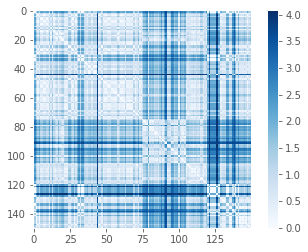

In [10]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();
plt.show()

# SVM Linear Classifier

In [11]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

In [12]:
strat_k_fold = StratifiedKFold(n_splits = 10, shuffle = True) # 10

In [13]:
clf = svm.SVC(kernel="linear", C = 1.0)
scores_ln = cross_val_score(clf, D, shock_labels, cv = 10)
np.mean(scores_ln)

0.39

In [14]:
clf = svm.SVC(kernel="linear", C = 1.0)
scores_ln = cross_val_score(clf, D, shock_labels, cv = strat_k_fold)
print(str(np.min(scores_ln)) +" - "+str(np.mean(scores_ln))+ " - " + str(np.max(scores_ln)) + " - "+ str(np.std(scores_ln)))

0.3 - 0.44000000000000006 - 0.7 - 0.11135528725660043


In [15]:
multi_clf = OneVsRestClassifier(estimator = clf)
scores_multi_ln = cross_val_score(multi_clf, D, shock_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_multi_ln)

0.48500000000000004

In [16]:
multi_clf = OneVsOneClassifier(estimator = clf)
scores_multi_ln = cross_val_score(multi_clf, D, shock_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_multi_ln)

0.41999999999999993

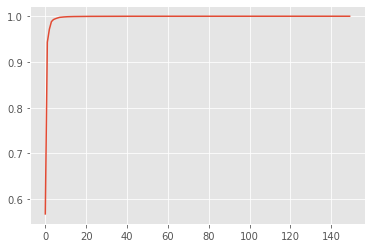

array([0.56774148, 0.94319994, 0.97173639])

In [17]:
PCA_D = PCA(n_components = 2).fit_transform(D)
plt.plot(np.cumsum(PCA().fit(D).explained_variance_ratio_))
plt.show()
np.cumsum(PCA().fit(D).explained_variance_ratio_)[:3]

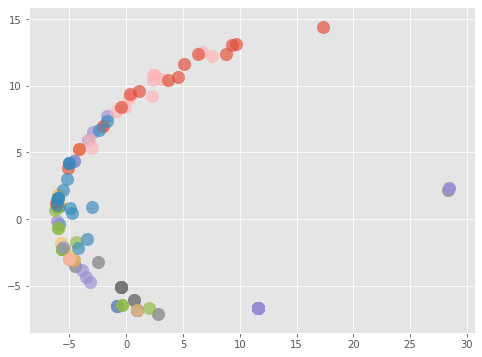

In [18]:
plt.figure(figsize=(8,6))
n_classes = 10
for i in range(n_classes):
    plt.scatter(PCA_D[shock_labels == i,0], PCA_D[shock_labels == i,1], s = 155, alpha = 0.65)
    
plt.axis('tight');
plt.style.use("ggplot")
plt.show()

# Manifold Learning Isomap

In [19]:
n_neighbors = 15#15
n_components = 2
iso_prj_D = manifold.Isomap(n_neighbors, n_components).fit_transform(D)

In [20]:
scores_ln = cross_val_score(clf, iso_prj_D, shock_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_ln)

0.33499999999999996

It seems that manifold learning with Isomap does not improve the performance of our linear svm classifier

In [21]:
multi_clf = OneVsOneClassifier(estimator = clf)
scores_multi_ln = cross_val_score(multi_clf, iso_prj_D, shock_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_multi_ln)

0.36

In [22]:
multi_clf = OneVsRestClassifier(estimator = clf)
scores_multi_ln = cross_val_score(multi_clf, iso_prj_D, shock_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_multi_ln)

0.12000000000000002

### Plots for Isomap

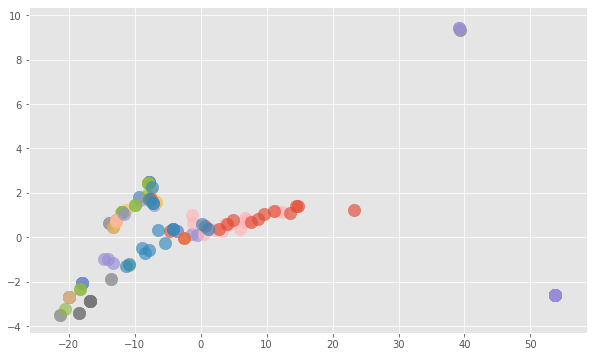

In [23]:
plt.figure(figsize=(10,6))
n_classes = 10
for i in range(n_classes):
    plt.scatter(iso_prj_D[shock_labels == i,0], iso_prj_D[shock_labels == i,1], s = 155, alpha = 0.65)
    
plt.axis('tight');
plt.grid(True)
plt.show()

#### Fit with best n of components

In [24]:
n_neighbors = 14
opt_n_components = fit_n_components(D, shock_labels, manifold.LocallyLinearEmbedding, n_neighbors)
opt_n_components

12

In [25]:
opt_iso_prj_D = manifold.Isomap(n_neighbors, opt_n_components).fit_transform(D)

In [26]:
scores_ln = cross_val_score(clf, opt_iso_prj_D, shock_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_ln)


0.45499999999999996

#  Manifold Learning LocalLinearEmbedding

In [27]:
lle_prj_D = manifold.LocallyLinearEmbedding(30, n_components).fit_transform(D)

In [28]:
scores_ln = cross_val_score(clf, lle_prj_D, shock_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_ln)

0.225

It seems that also manifold learning with LocalLinearEmbedding does not improve the performance of our linear svm classifier

In [29]:
multi_clf = OneVsRestClassifier(estimator = clf)
scores_multi_ln = cross_val_score(multi_clf, lle_prj_D, shock_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_multi_ln)

0.175

In [30]:
multi_clf = OneVsOneClassifier(estimator = clf)
scores_multi_ln = cross_val_score(multi_clf, lle_prj_D, shock_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_multi_ln)

0.21000000000000002

### Plot for LocalLinearEmbedding

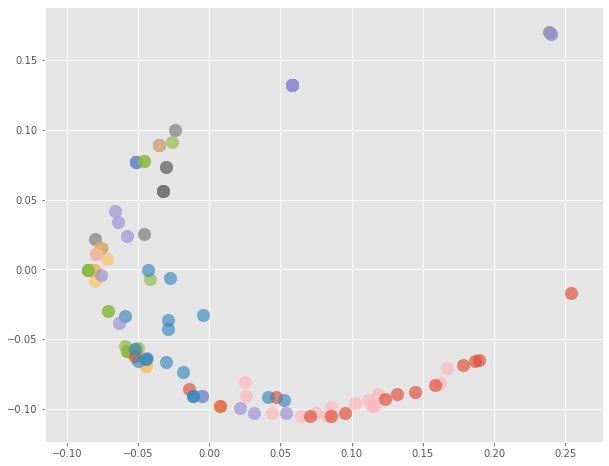

In [31]:
plt.figure(figsize=(10,8))
n_classes = 10
for i in range(n_classes):
    plt.scatter(lle_prj_D[shock_labels == i,0], lle_prj_D[shock_labels == i,1], s = 155, alpha = 0.65)
    
plt.axis('tight');
plt.grid(True)
plt.show()

#### Fit with best n of components

In [32]:
n_neighbors = 14
opt_n_components = fit_n_components(D, shock_labels, manifold.LocallyLinearEmbedding, n_neighbors)
opt_n_components

12

In [33]:
opt_lle_prj_D = manifold.LocallyLinearEmbedding(n_neighbors, opt_n_components).fit_transform(D)

In [34]:
scores_ln = cross_val_score(clf, opt_lle_prj_D, shock_labels, cv = strat_k_fold, n_jobs= 8)
np.mean(scores_ln)

0.4450000000000001